In [1]:
# # Purpose
# The purpose of this notebook is to manually execute the PC Algorithm (Section 5.4.2) of
# > Spirtes, P., Glymour, C., & Scheines, R. (1993). Causation, prediction, and search.
#
# This algorithm was chosen as one of the earliest causal discovery algorithms and one of the easiest for me (Timothy Brathwaite) to understand upon first read.
#
# The algorithm is given as follows (p.117):
# 1. Form the complete undirected graph C on the vertex set V.
# 2. n = 0.
#    - repeat
#        - repeat
#           - Select an ordered pair of variables X and Y that are adjacent in C such that Adjacencies(C,X)\\{Y} has cardinality greater than or equal to n, and a subset S of Adjacencies(C,X)\\{Y} of cardinality n, and if X and Y are d-separated given S, delete edge X - Y from C and record S in Sepset(X,Y) and Sepset(Y,X);
#        - until all ordered pairs of adjacent variables X and Y such that Adjacencies(C,X)\\{Y} has cardinality greater than or equal to n and all subsets S of Adjacencies(C,X)\\{Y} of cardinality n have been tested for d-separation;
#    - n = n + 1;
#    - until for each ordered pair of adjacent vertices X, Y, Adjacencies(C,X)\\{Y} is of cardinality less than n.
# 3. For each triple of vertices X, Y, Z such that the pair X, Y and the pair Y, Z are each adjacent in C but the pair X , Z are not adjacent in C, orient X - Y - Z as X -> Y <- Z if and only if Y is not in Sepset(X ,Z).
# 4. repeat
#    - If A -> B, B and C are adjacent, A and C are not adjacent, and there is no arrowhead at B, then orient B - C as B -> C.
#    - If there is a directed path from A to B, and an edge between A and B, then orient A - B as A -> B.
#
# until no more edges can be oriented.
#
# These steps will be informally and pragmatically carried out below.
#

In [ ]:
# Declare paths to data
DATA_PATH = "../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv"

# Note the columns of interest for this notebook
MODE_ID_COLUMN = "mode_id"
OBS_ID_COLUMN = "observation_id"

TIME_COLUMN = "total_travel_time"
COST_COLUMN = "total_travel_cost"
DISTANCE_COLUMN = "total_travel_distance"
LICENSE_COLUMN = "num_licensed_drivers"
NUM_AUTOS_COLUMN = "num_cars"

UTILITY_COLUMNS = [
    TIME_COLUMN,
    COST_COLUMN,
    DISTANCE_COLUMN,
    LICENSE_COLUMN,
    NUM_AUTOS_COLUMN,
]

# Note the travel mode of intersest for this notebook
DRIVE_ALONE_ID = 1

# Note the number of permutations to be used when
# testing the causal graphs
NUM_PERMUTATIONS = 100

# Choose a color to represent reference /
# permutation-based test statistics
PERMUTED_COLOR = "#a6bddb"

# Declare a title for the discovered causal graph
PLOT_TITLE = "discovery-example-graph"

In [3]:
# Built-in modules
import itertools  # noqa: E402 isort:skip
import sys  # noqa: E402 isort:skip
from typing import Optional, Tuple  # noqa: E402 isort:skip

# Third party modules
import graphviz  # noqa: E402 isort:skip
import numpy as np  # noqa: E402 isort:skip
import pandas as pd  # noqa: E402 isort:skip

# Local modules
# noreorder
sys.path.insert(0, "../../")
import src.testing.observable_independence as oi  # noqa: E402
import src.utils as utils  # noqa: E402
from src.graphs.drive_alone_utility import DRIVE_ALONE_UTILITY  # noqa: E402

In [4]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

# Look at the data being used in this notebook
print(
    df.loc[
        df[MODE_ID_COLUMN] == DRIVE_ALONE_ID, UTILITY_COLUMNS + [OBS_ID_COLUMN]
    ]
    .head(5)
    .T
)

# Create a dataframe with the variables posited
# to make up the drive-alone utility
drive_alone_df = df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID, UTILITY_COLUMNS]

# Figure out how many observations we have with
# the drive alone mode being available
num_drive_alone_obs = drive_alone_df.shape[0]


                           0        8        16       24       32
total_travel_time      54.010  39.7800  22.2200  22.3000  47.9500
total_travel_cost       5.714   4.4519   1.6817   1.6817   5.9782
total_travel_distance  30.920  24.0900   9.1000   9.1000  32.3500
num_licensed_drivers    2.000   2.0000   2.0000   2.0000   2.0000
num_cars                2.000   2.0000   2.0000   2.0000   2.0000
observation_id          1.000   2.0000   3.0000   4.0000   5.0000


# PC Algorithm

Note that the numbering of steps below differs from the original numbering given above in the description of the PC algorithm.
Here, each step is a single action taken to either update the graph or test what edges should be removed from the graph.

## Step 1: construct the fully connected graph

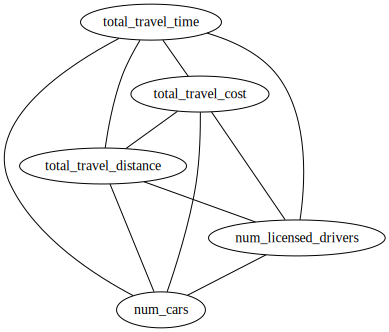

In [5]:
step_1_graph = graphviz.Graph("step_1")

# Add all nodes to the graph
step_1_graph.node("T", TIME_COLUMN)
step_1_graph.node("C", COST_COLUMN)
step_1_graph.node("D", DISTANCE_COLUMN)
step_1_graph.node("L", LICENSE_COLUMN)
step_1_graph.node("A", NUM_AUTOS_COLUMN)

# Create a fully connected, undirected graph
node_aliases = ["T", "C", "D", "L", "A"]
step_1_graph.edges(list(itertools.combinations(node_aliases, 2)))

# Display the graph
step_1_graph

## Step 2 : Test all "0-order interactions," i.e., marginal independencies

100%|██████████| 100/100 [00:00<00:00, 954.17it/s]

total_travel_time vs total_travel_cost:
The p-value of the permutation independence test is 0.00.


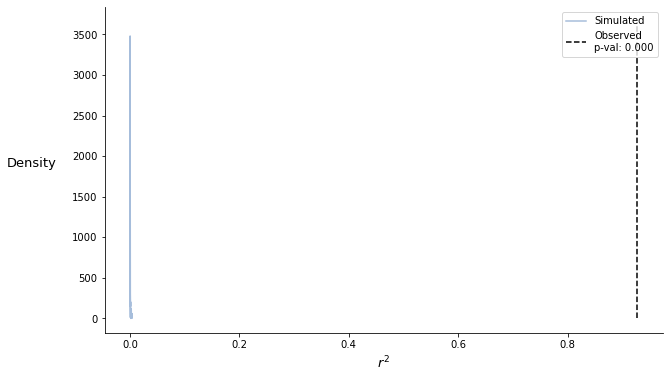

100%|██████████| 100/100 [00:00<00:00, 1132.92it/s]

total_travel_time vs total_travel_distance:
The p-value of the permutation independence test is 0.00.


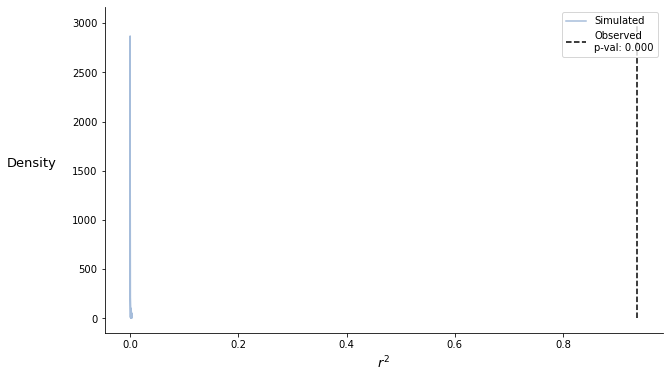

100%|██████████| 100/100 [00:00<00:00, 1142.18it/s]

total_travel_time vs num_licensed_drivers:
The p-value of the permutation independence test is 0.31.


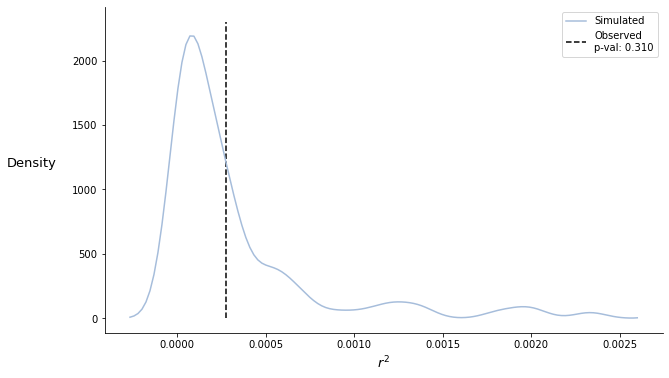

100%|██████████| 100/100 [00:00<00:00, 1030.29it/s]

total_travel_time vs num_cars:
The p-value of the permutation independence test is 0.01.


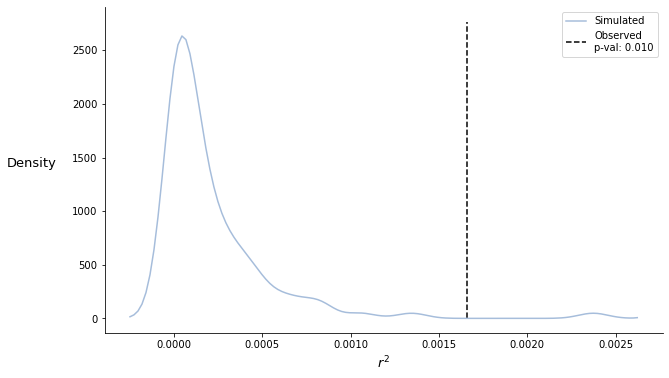

100%|██████████| 100/100 [00:00<00:00, 1075.79it/s]

total_travel_cost vs total_travel_distance:
The p-value of the permutation independence test is 0.00.


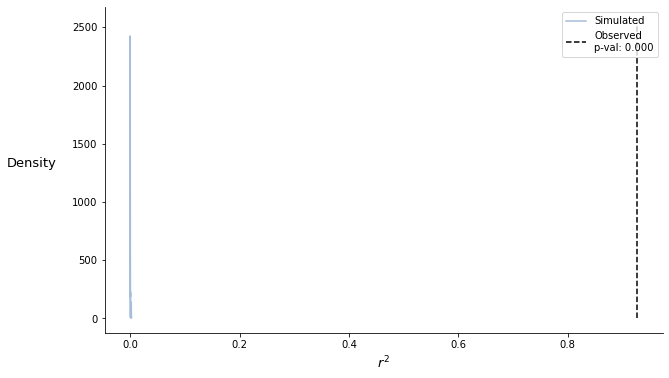

100%|██████████| 100/100 [00:00<00:00, 1124.57it/s]

total_travel_cost vs num_licensed_drivers:
The p-value of the permutation independence test is 0.32.


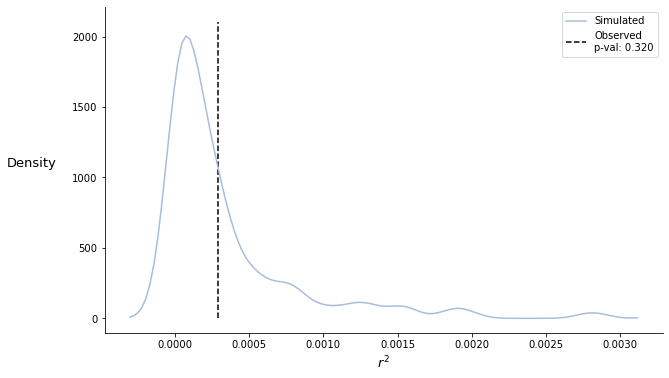

100%|██████████| 100/100 [00:00<00:00, 930.92it/s]

total_travel_cost vs num_cars:
The p-value of the permutation independence test is 0.00.


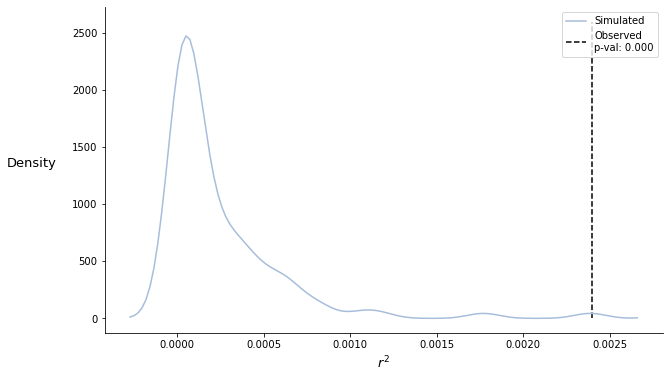

100%|██████████| 100/100 [00:00<00:00, 1100.50it/s]

total_travel_distance vs num_licensed_drivers:
The p-value of the permutation independence test is 0.91.


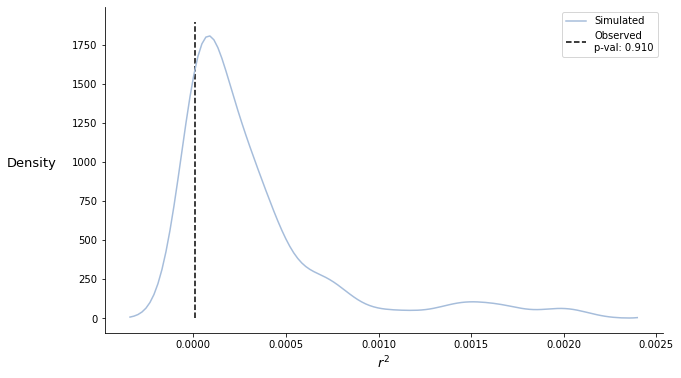

100%|██████████| 100/100 [00:00<00:00, 1081.49it/s]

total_travel_distance vs num_cars:
The p-value of the permutation independence test is 0.00.


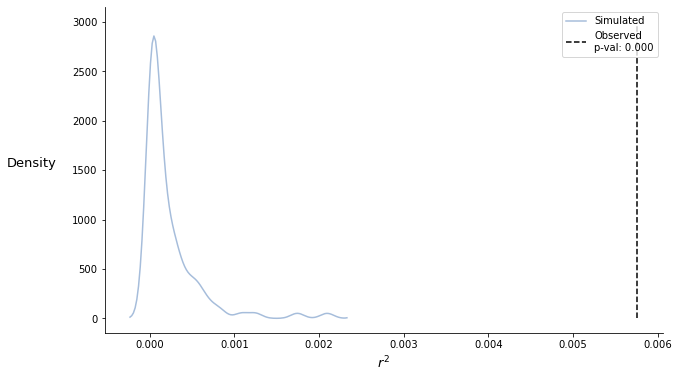

100%|██████████| 100/100 [00:00<00:00, 1032.33it/s]

num_licensed_drivers vs num_cars:
The p-value of the permutation independence test is 0.00.


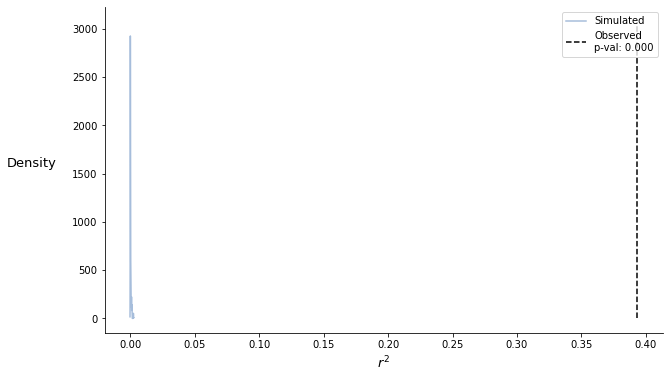

In [6]:
# Get all pairs of variables
col_pairs = list(itertools.combinations(UTILITY_COLUMNS, 2))

# Set a seed for reproducbility
np.random.seed(938)

# Test the marginal independencies of all pairs of variables
for col_1, col_2 in col_pairs:
    col_1_array = drive_alone_df[col_1].values
    col_2_array = drive_alone_df[col_2].values

    print("{} vs {}:".format(col_1, col_2))
    oi.visual_permutation_test(
        col_1_array,
        col_2_array,
        z_array=None,
        num_permutations=NUM_PERMUTATIONS,
        permutation_color=PERMUTED_COLOR,
    )

From the results above, the joint distributions of the following variable pairs merit further investigation for marginal independence:
- total_travel_distance vs num_licensed_drivers
- total_travel_cost vs num_licensed_drivers
- total_travel_time vs num_licensed_drivers

I should take the following investigatory actions:
1. Look at the data, i.e., the bivariate plots of the pairs of variables.
2. Examine the data summaries, i.e. the models, being used for under-fitting and sensibility (e.g. should this be a linear regression at all?).
3. Check whether the suggested independencies (alone and as a collection) make sense logically.
4. Try a predictive independence test based on predicting the variance of the conditional distributions instead of predicting the mean.

For now though, I'm going to keep going tonight (June 15th, 2020) in an attempt to learn as many new things as possible, instead of doing the most thorough job I can on each substep.
I will come back to the actions listed above.

## Step 3: Update the working graph

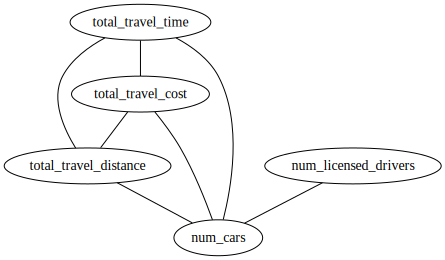

In [7]:
####
# Remove the edges given by the pairs of variables
# that passed the marginal independence tests.
####
step_3_graph = graphviz.Graph("step_3")

# Add all nodes to the graph
step_3_graph.node("T", TIME_COLUMN)
step_3_graph.node("C", COST_COLUMN)
step_3_graph.node("D", DISTANCE_COLUMN)
step_3_graph.node("L", LICENSE_COLUMN)
step_3_graph.node("A", NUM_AUTOS_COLUMN)

# Create a fully connected, undirected graph
node_aliases = ["T", "C", "D", "A"]
step_3_graph.edges(list(itertools.combinations(node_aliases, 2)))
step_3_graph.edge("L", "A")

# Display the graph
step_3_graph

## Step 4: Test for all "1st-order" interactions, i.e., conditional independences

In [8]:
triplets = list(itertools.permutations(UTILITY_COLUMNS, 3))

100%|██████████| 100/100 [00:00<00:00, 820.82it/s]

total_travel_time indep total_travel_cost given total_travel_distance:
The p-value of the permutation independence test is 0.00.


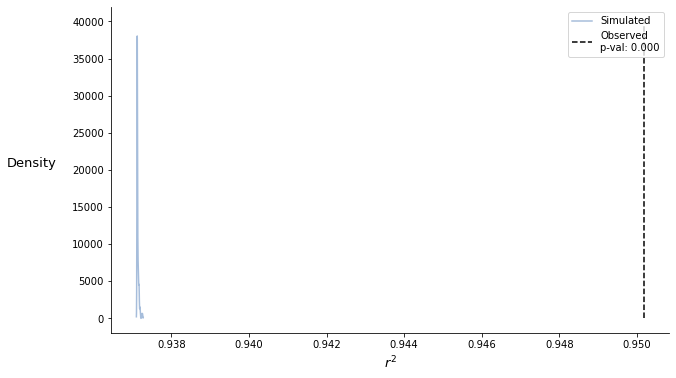

100%|██████████| 100/100 [00:00<00:00, 895.60it/s]

total_travel_time indep total_travel_cost given num_licensed_drivers:
The p-value of the permutation independence test is 0.00.


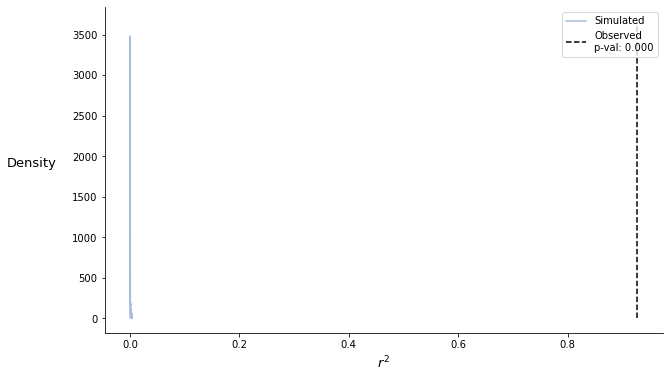

100%|██████████| 100/100 [00:00<00:00, 961.18it/s]

total_travel_time indep total_travel_cost given num_cars:
The p-value of the permutation independence test is 0.00.


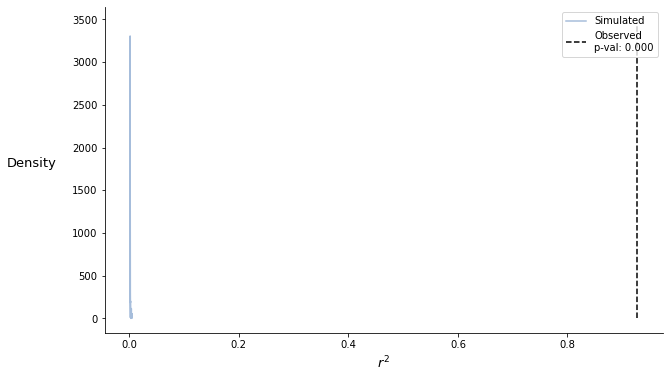

100%|██████████| 100/100 [00:00<00:00, 888.49it/s]

total_travel_time indep total_travel_distance given total_travel_cost:
The p-value of the permutation independence test is 0.00.


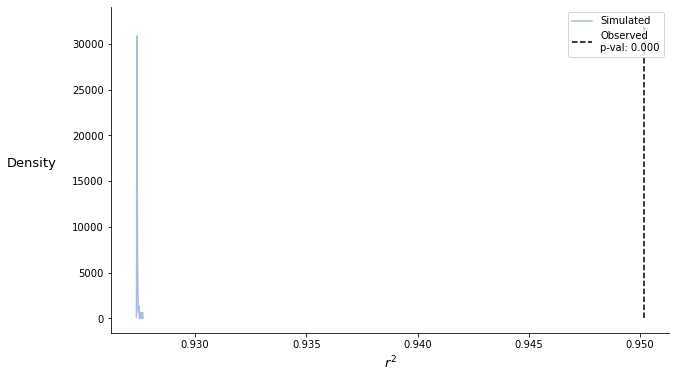

100%|██████████| 100/100 [00:00<00:00, 895.47it/s]

total_travel_time indep total_travel_distance given num_licensed_drivers:
The p-value of the permutation independence test is 0.00.


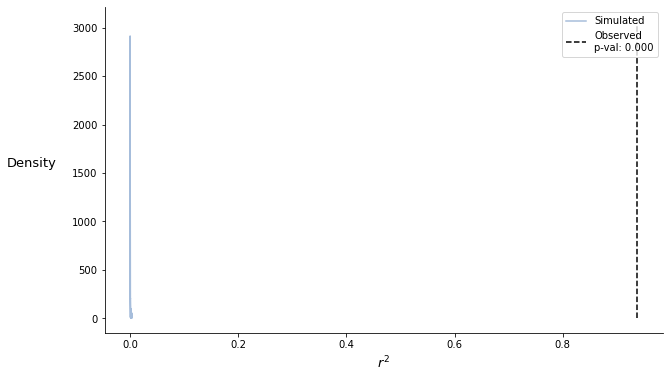

100%|██████████| 100/100 [00:00<00:00, 885.38it/s]

total_travel_time indep total_travel_distance given num_cars:


The p-value of the permutation independence test is 0.00.


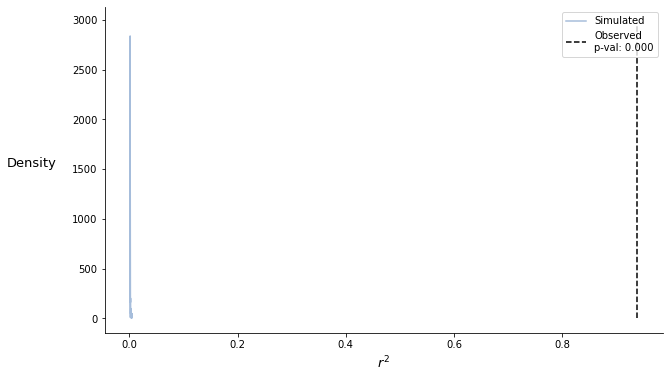

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_time indep num_licensed_drivers given total_travel_cost:


100%|██████████| 100/100 [00:00<00:00, 847.28it/s]

The p-value of the permutation independence test is 0.94.


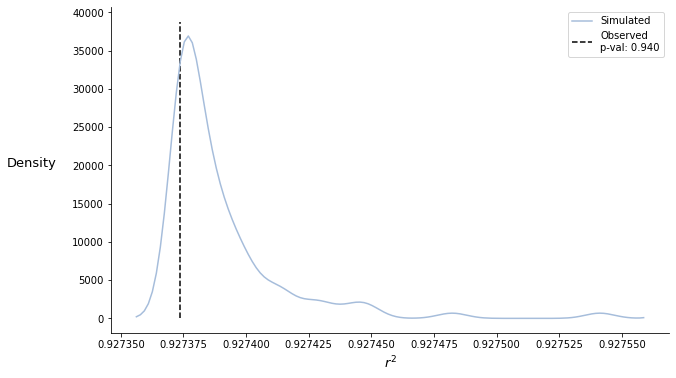

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_time indep num_licensed_drivers given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 917.80it/s]

The p-value of the permutation independence test is 0.00.


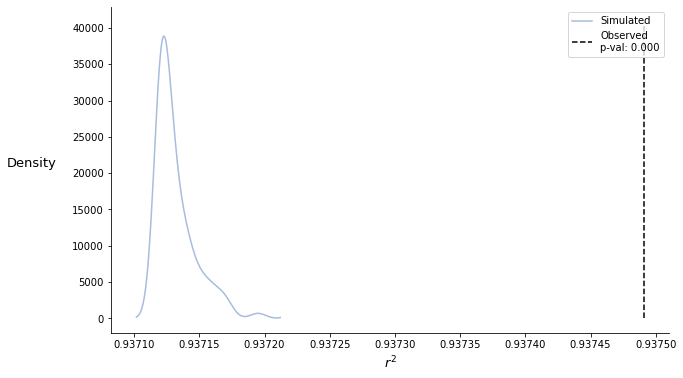

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_time indep num_licensed_drivers given num_cars:


100%|██████████| 100/100 [00:00<00:00, 841.28it/s]

The p-value of the permutation independence test is 0.00.


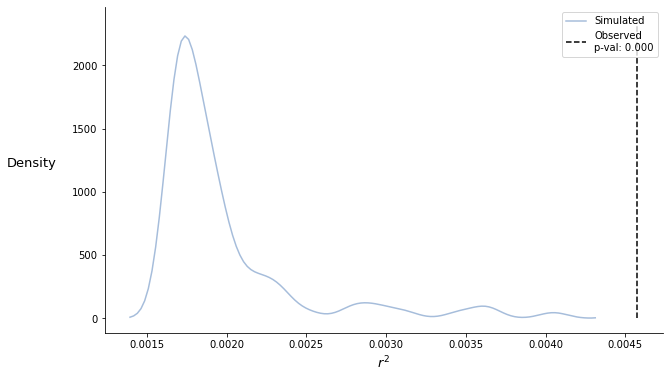

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_time indep num_cars given total_travel_cost:


100%|██████████| 100/100 [00:00<00:00, 670.22it/s]

The p-value of the permutation independence test is 0.13.


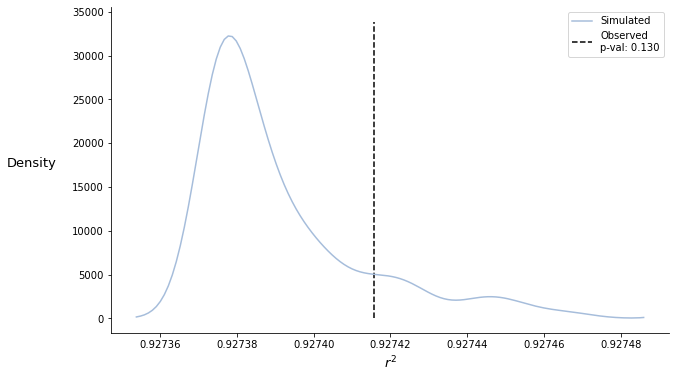

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_time indep num_cars given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 730.40it/s]

The p-value of the permutation independence test is 0.00.


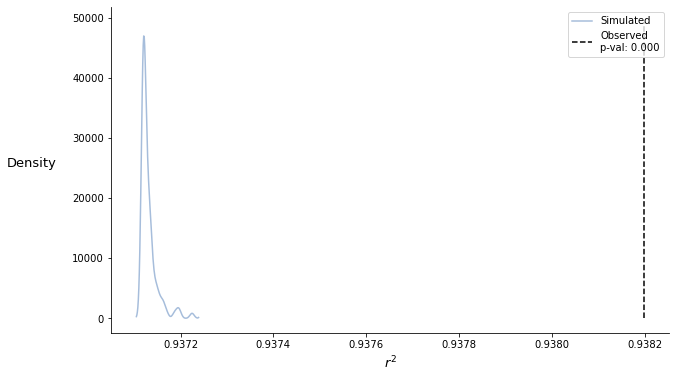

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_time indep num_cars given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 774.66it/s]

The p-value of the permutation independence test is 0.00.


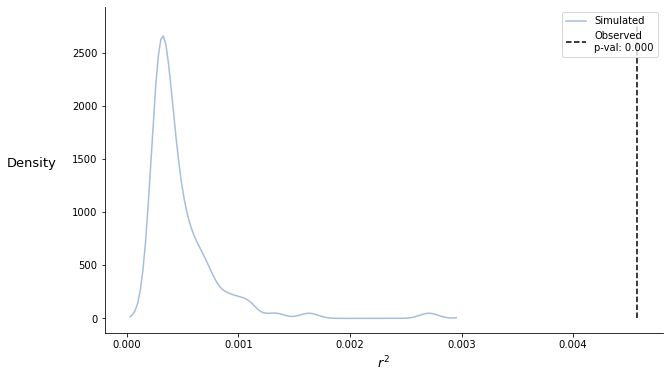

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep total_travel_time given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 615.22it/s]

The p-value of the permutation independence test is 0.00.


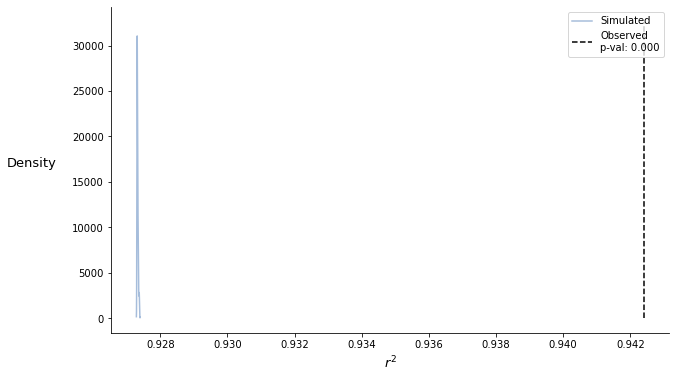

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep total_travel_time given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 681.63it/s]

The p-value of the permutation independence test is 0.00.


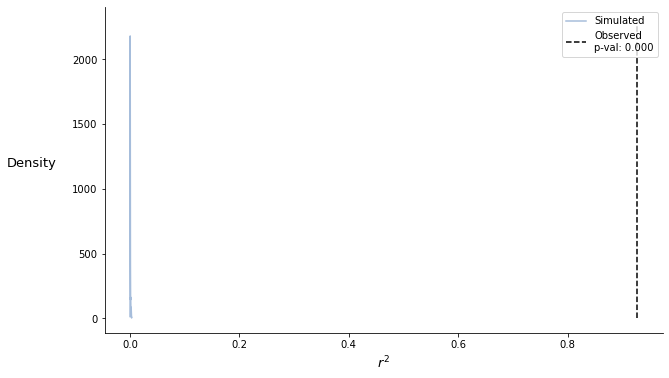

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep total_travel_time given num_cars:


100%|██████████| 100/100 [00:00<00:00, 773.21it/s]

The p-value of the permutation independence test is 0.00.


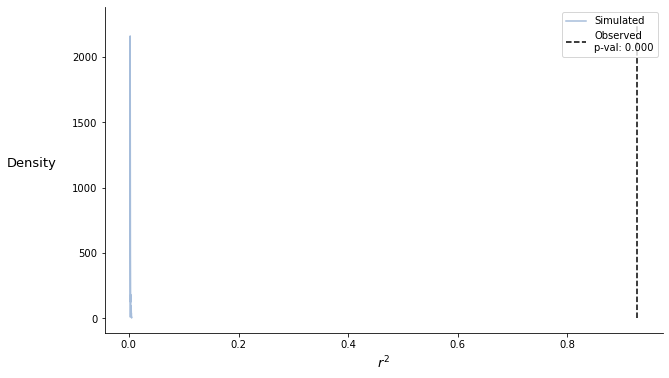

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep total_travel_distance given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 905.40it/s]

The p-value of the permutation independence test is 0.00.


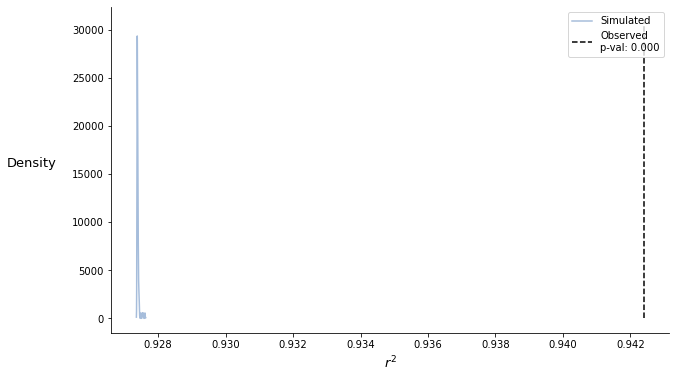

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep total_travel_distance given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 919.83it/s]

The p-value of the permutation independence test is 0.00.


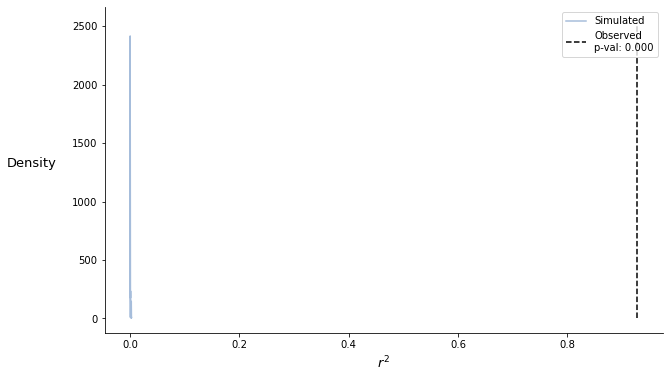

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep total_travel_distance given num_cars:


100%|██████████| 100/100 [00:00<00:00, 713.39it/s]

The p-value of the permutation independence test is 0.00.


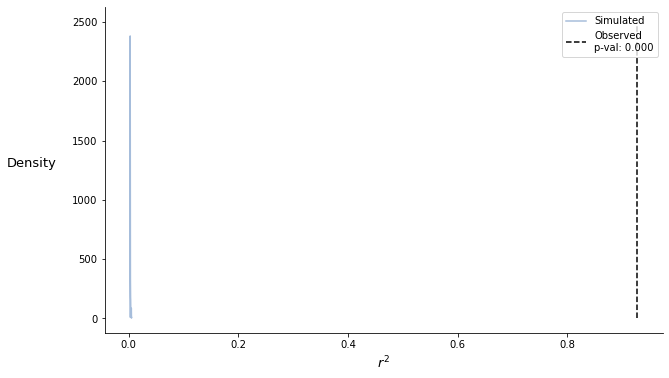

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep num_licensed_drivers given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 847.03it/s]

The p-value of the permutation independence test is 0.75.


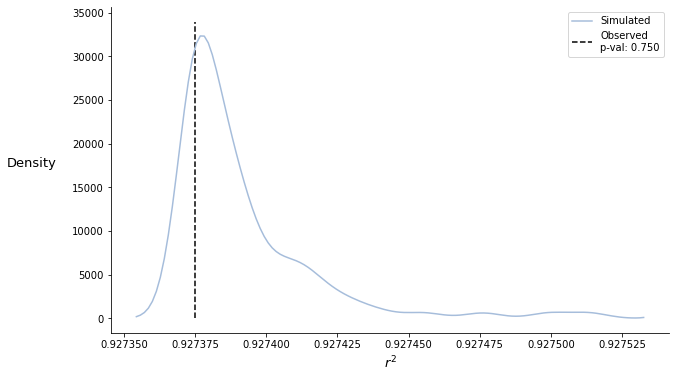

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep num_licensed_drivers given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 874.13it/s]

The p-value of the permutation independence test is 0.00.


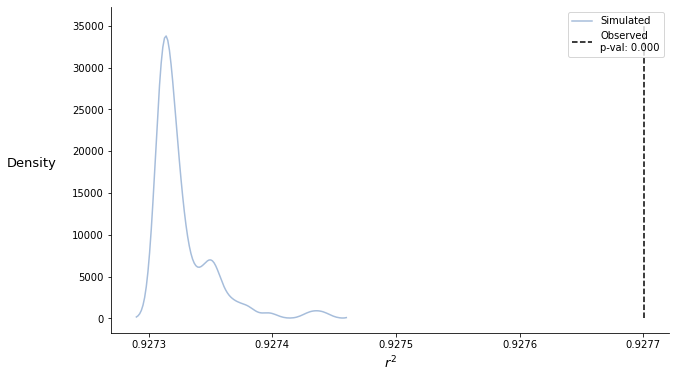

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep num_licensed_drivers given num_cars:


100%|██████████| 100/100 [00:00<00:00, 877.38it/s]

The p-value of the permutation independence test is 0.00.


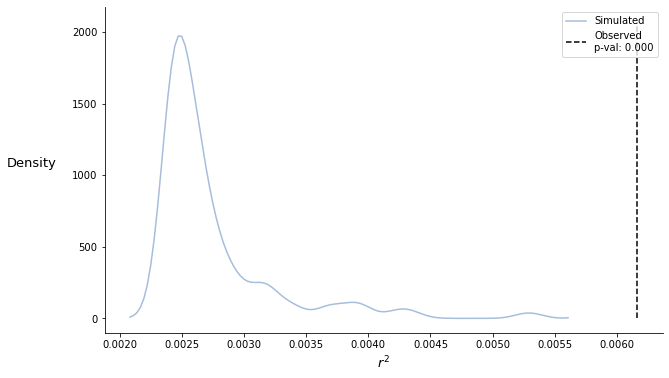

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep num_cars given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 773.81it/s]

The p-value of the permutation independence test is 0.02.


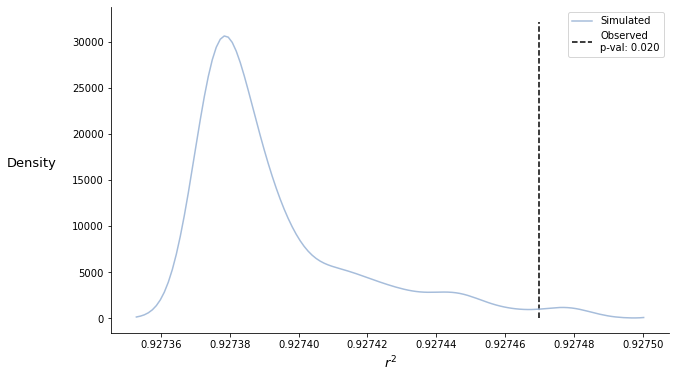

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep num_cars given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 805.96it/s]

The p-value of the permutation independence test is 0.00.


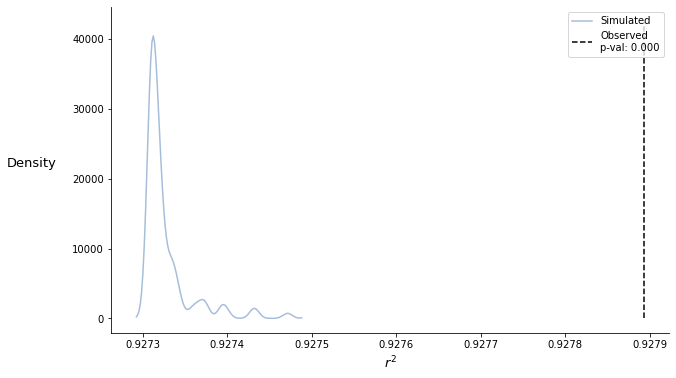

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_cost indep num_cars given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 868.37it/s]

The p-value of the permutation independence test is 0.00.


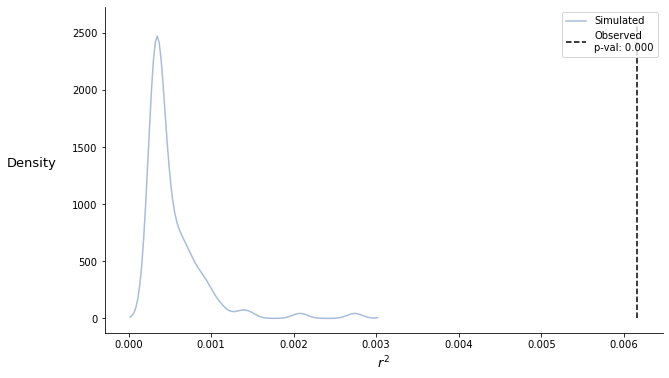

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_distance indep total_travel_time given total_travel_cost:


100%|██████████| 100/100 [00:00<00:00, 868.90it/s]

The p-value of the permutation independence test is 0.00.

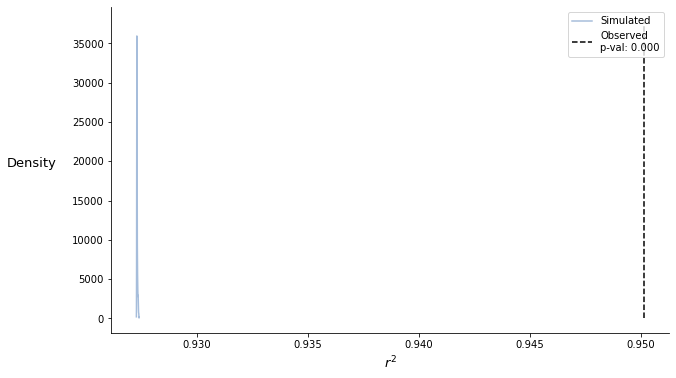

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_distance indep total_travel_time given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 884.45it/s]

The p-value of the permutation independence test is 0.00.


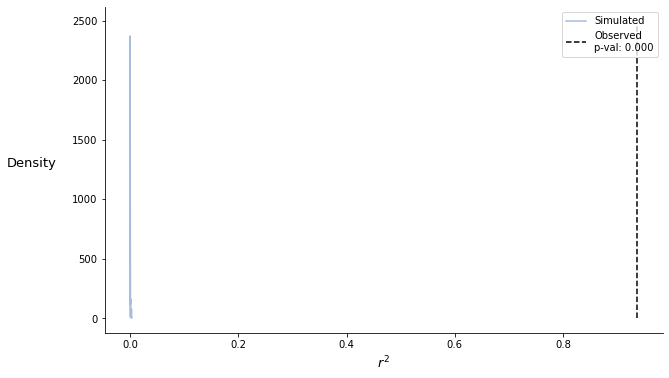

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_distance indep total_travel_time given num_cars:


100%|██████████| 100/100 [00:00<00:00, 888.19it/s]

The p-value of the permutation independence test is 0.00.


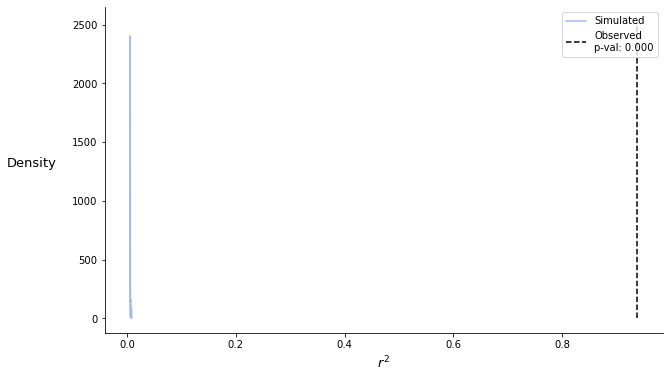

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_distance indep total_travel_cost given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 776.18it/s]

The p-value of the permutation independence test is 0.00.


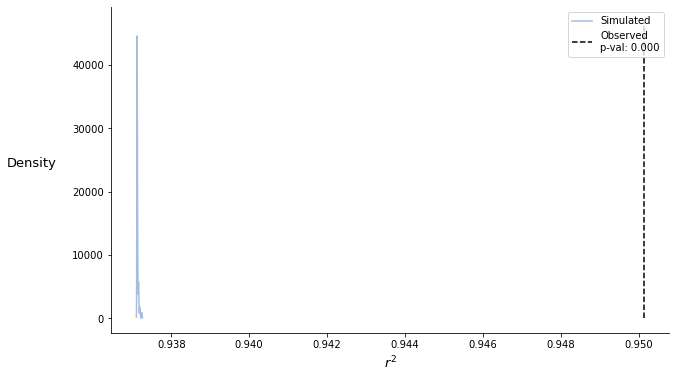

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_distance indep total_travel_cost given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 861.90it/s]

The p-value of the permutation independence test is 0.00.


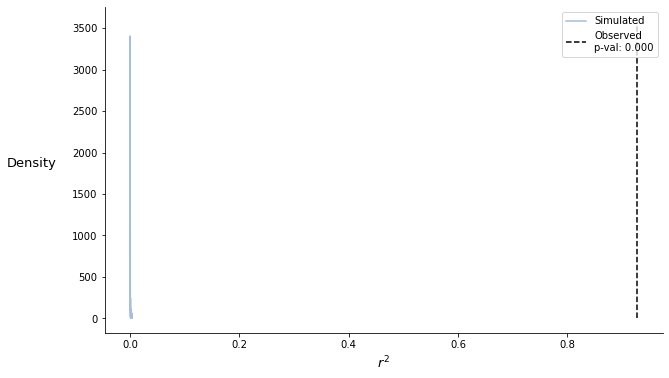

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_distance indep total_travel_cost given num_cars:


100%|██████████| 100/100 [00:00<00:00, 771.27it/s]

The p-value of the permutation independence test is 0.00.


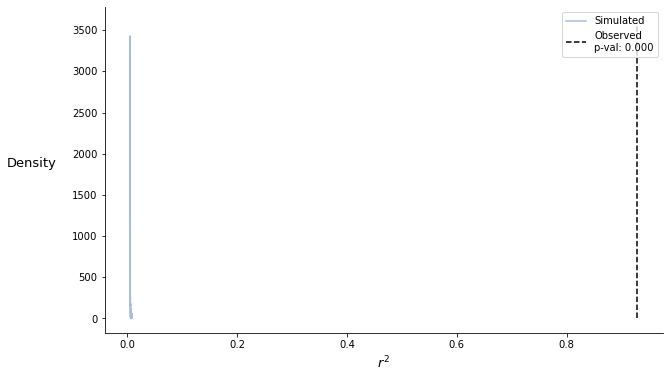

  0%|          | 0/100 [00:00<?, ?it/s]

total_travel_distance indep num_licensed_drivers given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 786.81it/s]

The p-value of the permutation independence test is 0.00.


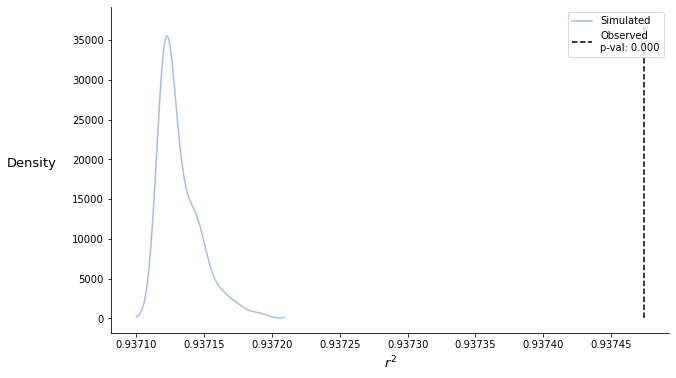

100%|██████████| 100/100 [00:00<00:00, 942.25it/s]

total_travel_distance indep num_licensed_drivers given total_travel_cost:
The p-value of the permutation independence test is 0.00.


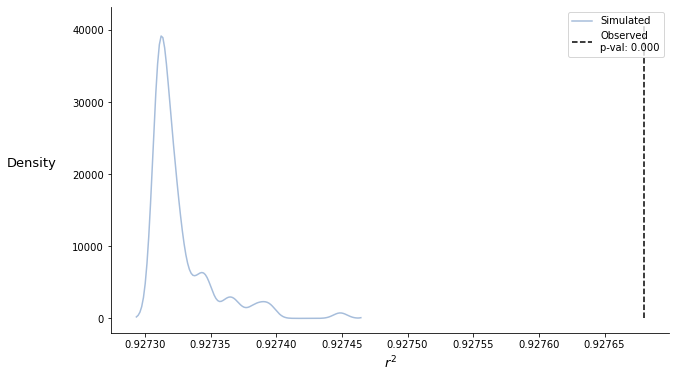

100%|██████████| 100/100 [00:00<00:00, 913.27it/s]

total_travel_distance indep num_licensed_drivers given num_cars:
The p-value of the permutation independence test is 0.00.


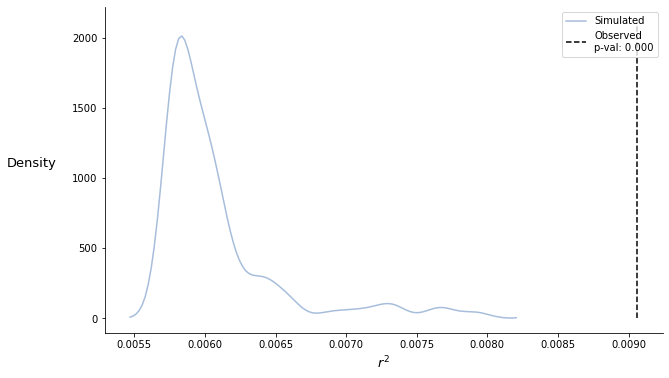

100%|██████████| 100/100 [00:00<00:00, 940.57it/s]

total_travel_distance indep num_cars given total_travel_time:
The p-value of the permutation independence test is 0.00.


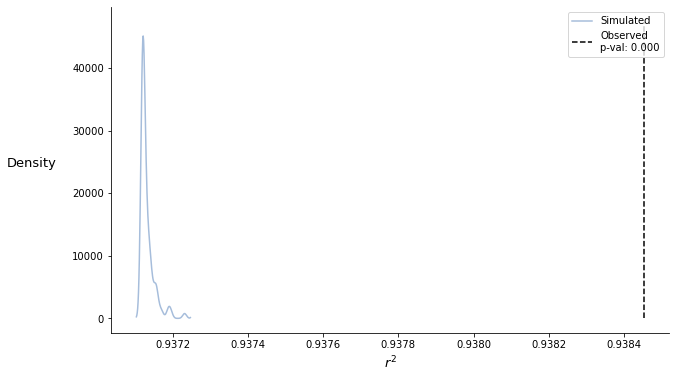

100%|██████████| 100/100 [00:00<00:00, 860.42it/s]

total_travel_distance indep num_cars given total_travel_cost:
The p-value of the permutation independence test is 0.00.


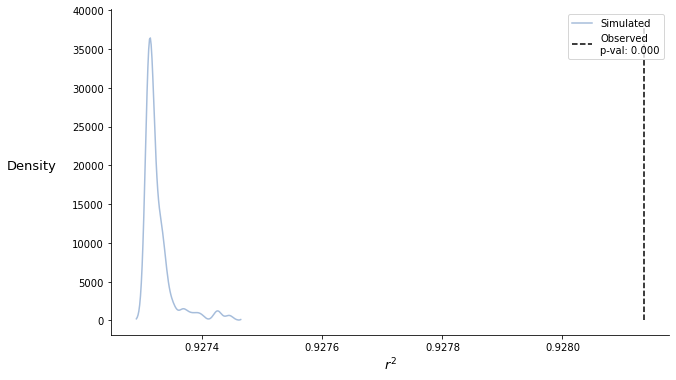

100%|██████████| 100/100 [00:00<00:00, 842.65it/s]

total_travel_distance indep num_cars given num_licensed_drivers:
The p-value of the permutation independence test is 0.00.


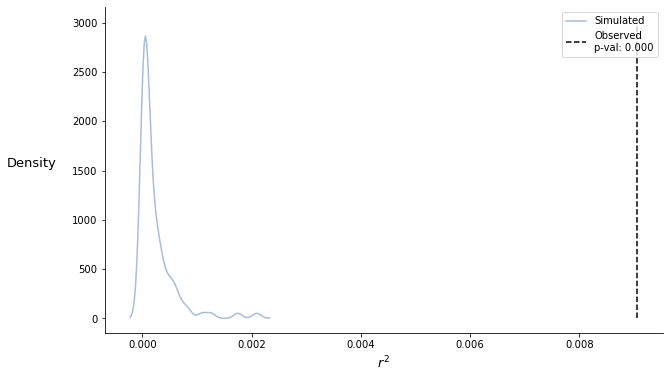

100%|██████████| 100/100 [00:00<00:00, 948.41it/s]

num_licensed_drivers indep total_travel_time given total_travel_cost:
The p-value of the permutation independence test is 0.98.


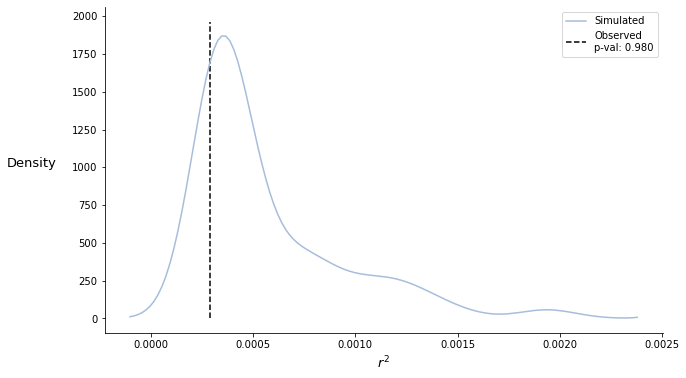

100%|██████████| 100/100 [00:00<00:00, 871.74it/s]

num_licensed_drivers indep total_travel_time given total_travel_distance:
The p-value of the permutation independence test is 0.00.


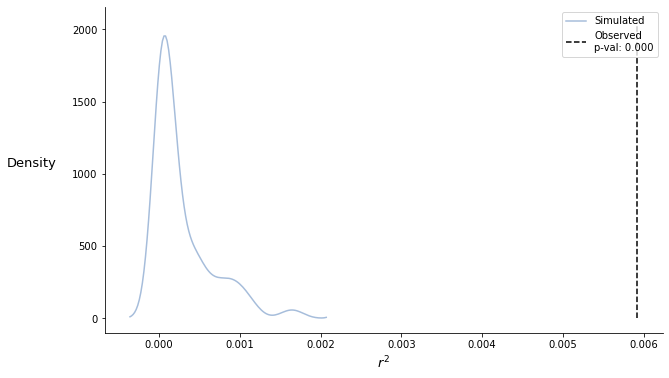

100%|██████████| 100/100 [00:00<00:00, 896.85it/s]

num_licensed_drivers indep total_travel_time given num_cars:
The p-value of the permutation independence test is 0.00.


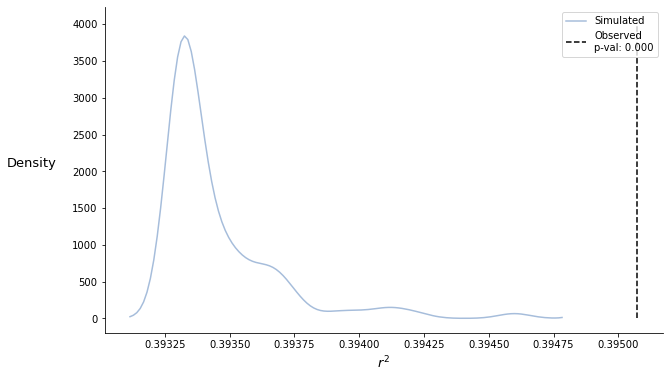

100%|██████████| 100/100 [00:00<00:00, 865.67it/s]

num_licensed_drivers indep total_travel_cost given total_travel_time:
The p-value of the permutation independence test is 0.79.


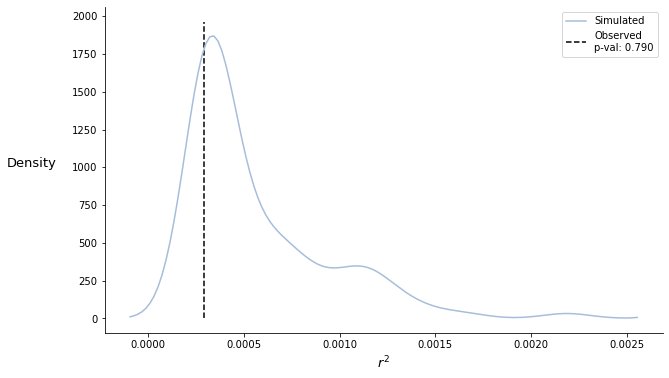

100%|██████████| 100/100 [00:00<00:00, 934.71it/s]

num_licensed_drivers indep total_travel_cost given total_travel_distance:
The p-value of the permutation independence test is 0.00.


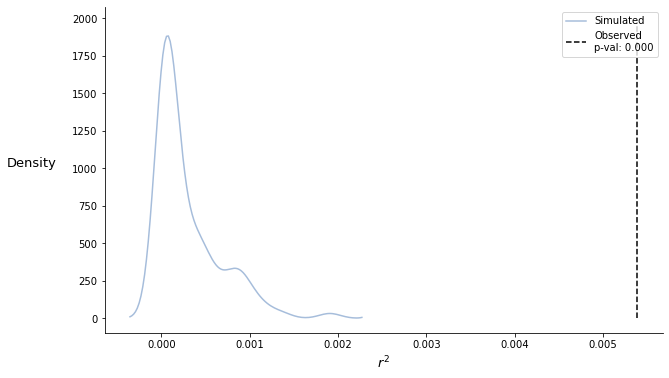

100%|██████████| 100/100 [00:00<00:00, 907.85it/s]

num_licensed_drivers indep total_travel_cost given num_cars:
The p-value of the permutation independence test is 0.00.


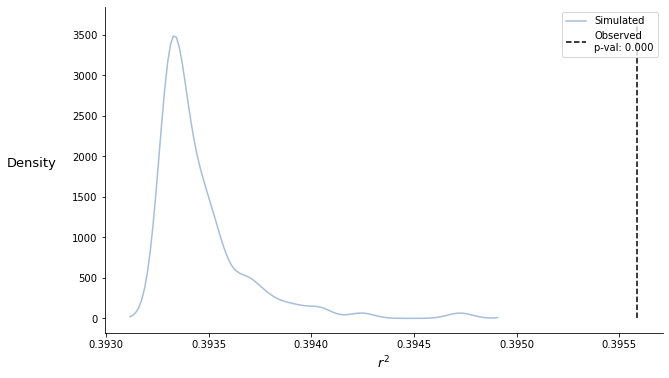

100%|██████████| 100/100 [00:00<00:00, 893.84it/s]

num_licensed_drivers indep total_travel_distance given total_travel_time:
The p-value of the permutation independence test is 0.00.


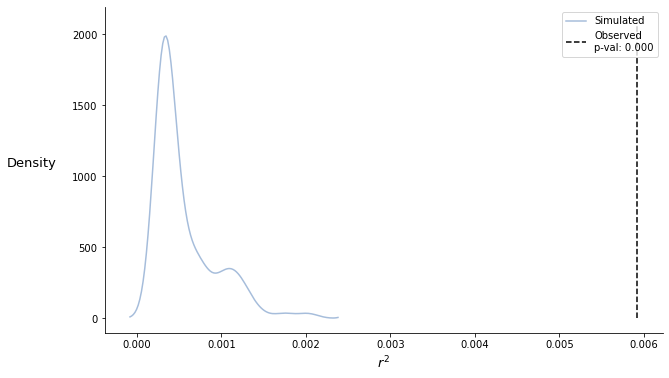

100%|██████████| 100/100 [00:00<00:00, 771.95it/s]

num_licensed_drivers indep total_travel_distance given total_travel_cost:


The p-value of the permutation independence test is 0.00.


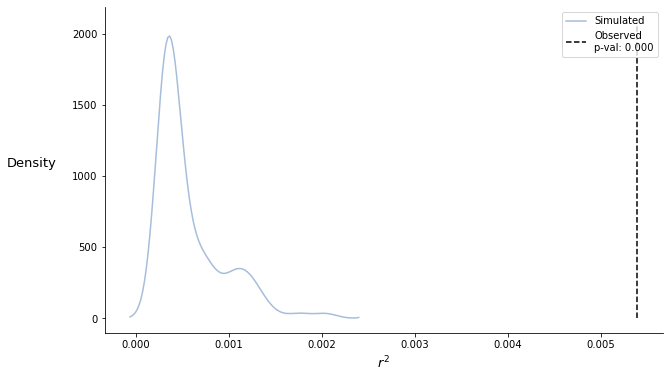

  0%|          | 0/100 [00:00<?, ?it/s]

num_licensed_drivers indep total_travel_distance given num_cars:


100%|██████████| 100/100 [00:00<00:00, 551.90it/s]

The p-value of the permutation independence test is 0.00.


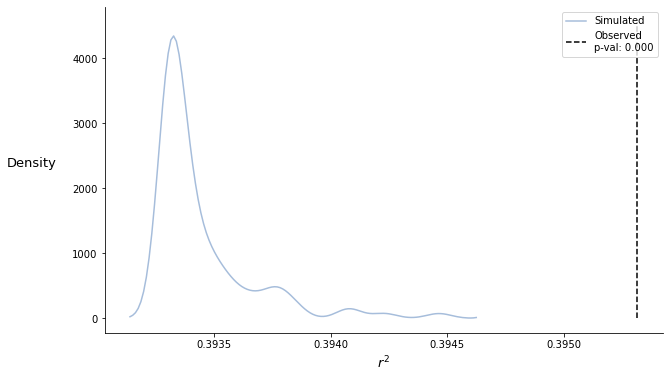

  0%|          | 0/100 [00:00<?, ?it/s]

num_licensed_drivers indep num_cars given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 892.62it/s]

The p-value of the permutation independence test is 0.00.


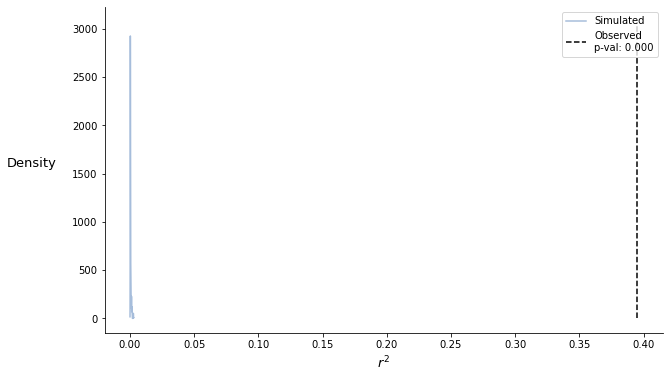

  0%|          | 0/100 [00:00<?, ?it/s]

num_licensed_drivers indep num_cars given total_travel_cost:


100%|██████████| 100/100 [00:00<00:00, 859.28it/s]

The p-value of the permutation independence test is 0.00.


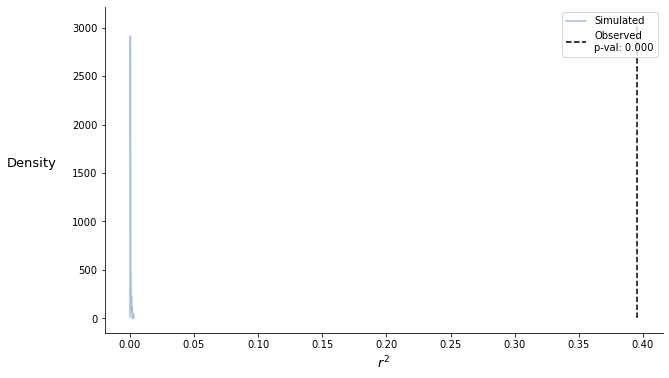

  0%|          | 0/100 [00:00<?, ?it/s]

num_licensed_drivers indep num_cars given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 803.04it/s]

The p-value of the permutation independence test is 0.00.


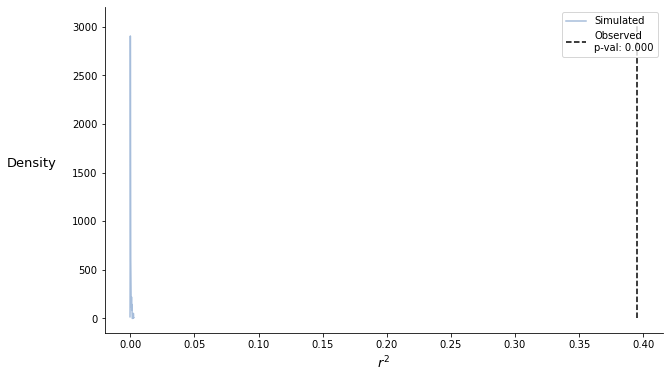

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_time given total_travel_cost:


100%|██████████| 100/100 [00:00<00:00, 842.46it/s]

The p-value of the permutation independence test is 0.16.


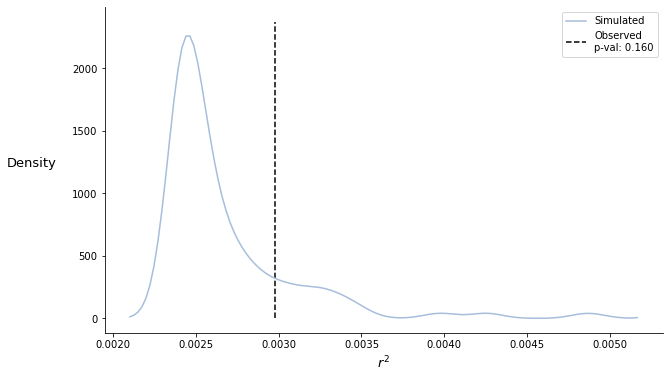

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_time given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 778.97it/s]

The p-value of the permutation independence test is 0.00.


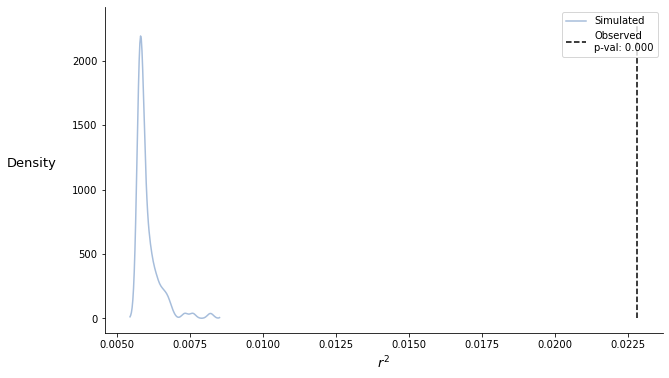

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_time given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 903.47it/s]

The p-value of the permutation independence test is 0.00.


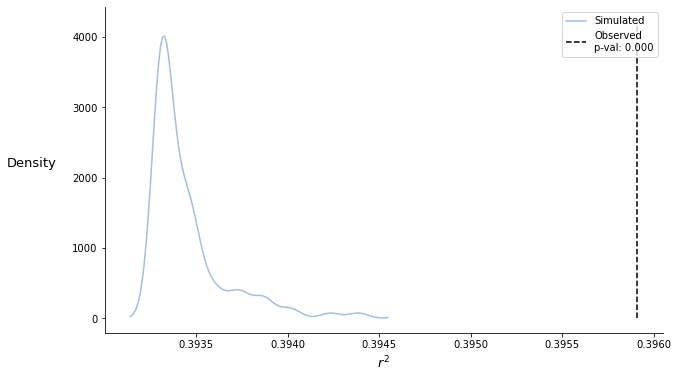

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_cost given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 891.80it/s]

The p-value of the permutation independence test is 0.03.


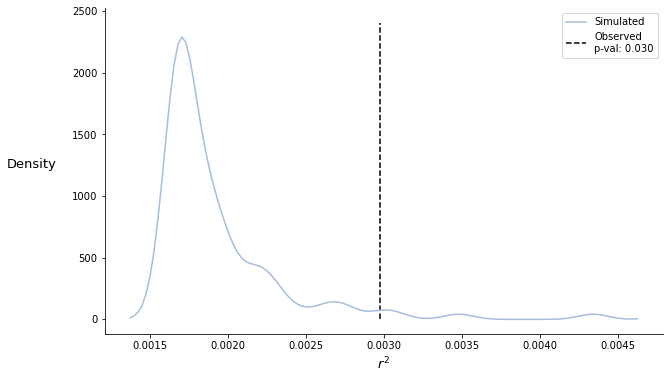

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_cost given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 815.13it/s]

The p-value of the permutation independence test is 0.00.


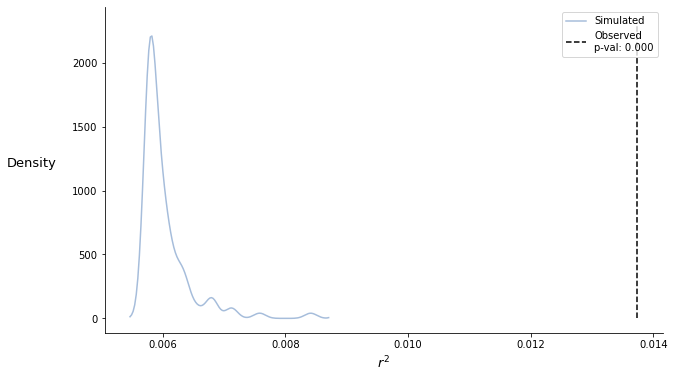

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_cost given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 875.96it/s]

The p-value of the permutation independence test is 0.00.


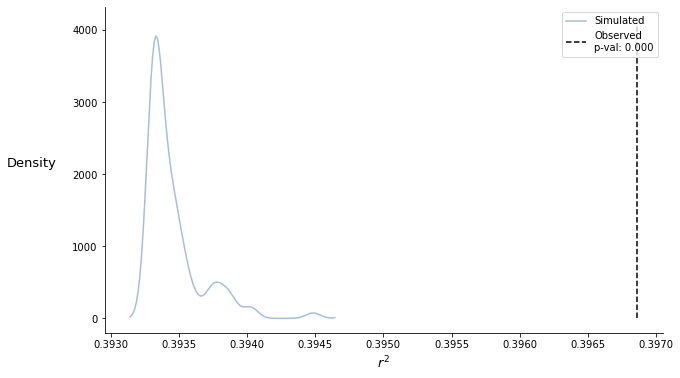

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_distance given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 821.79it/s]

The p-value of the permutation independence test is 0.00.


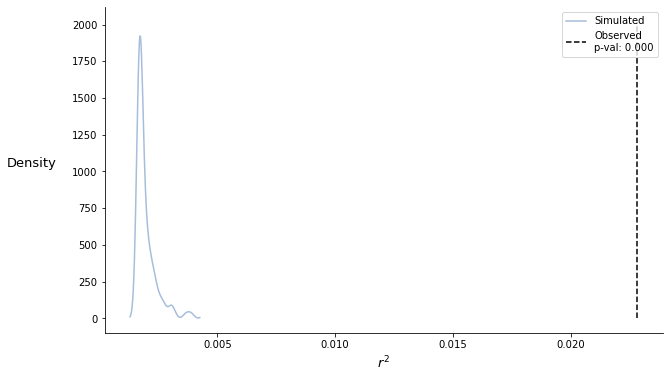

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_distance given total_travel_cost:


100%|██████████| 100/100 [00:00<00:00, 878.76it/s]

The p-value of the permutation independence test is 0.00.


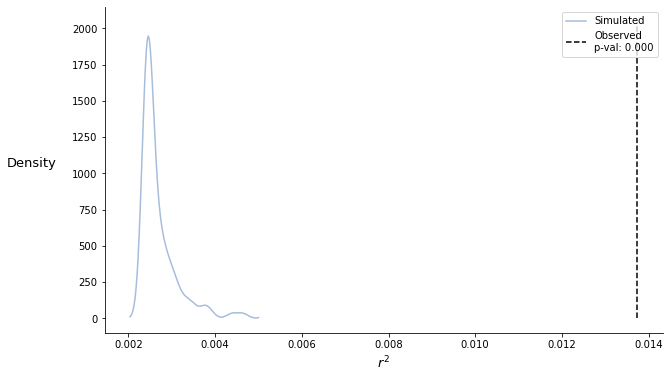

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep total_travel_distance given num_licensed_drivers:


100%|██████████| 100/100 [00:00<00:00, 864.32it/s]

The p-value of the permutation independence test is 0.00.


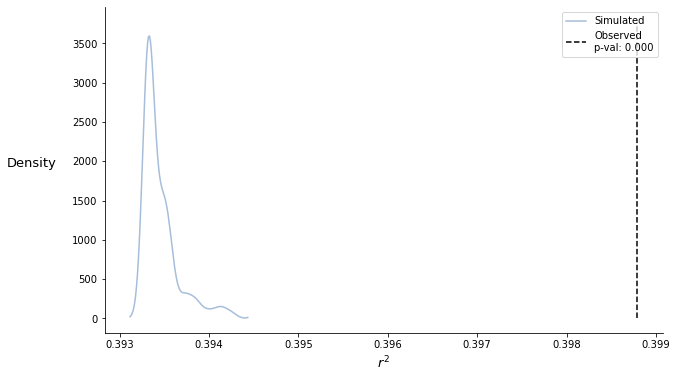

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep num_licensed_drivers given total_travel_time:


100%|██████████| 100/100 [00:00<00:00, 856.58it/s]

The p-value of the permutation independence test is 0.00.


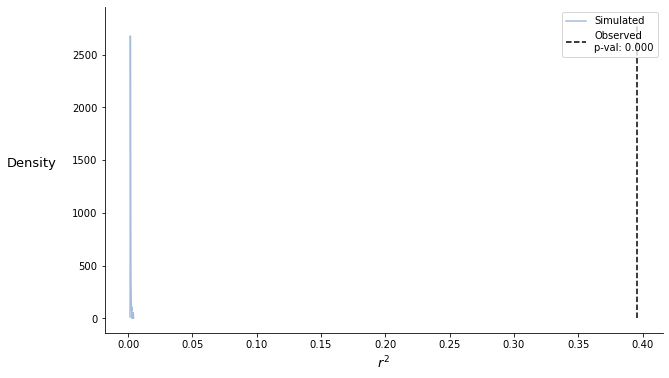

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep num_licensed_drivers given total_travel_cost:


100%|██████████| 100/100 [00:00<00:00, 877.39it/s]

The p-value of the permutation independence test is 0.00.


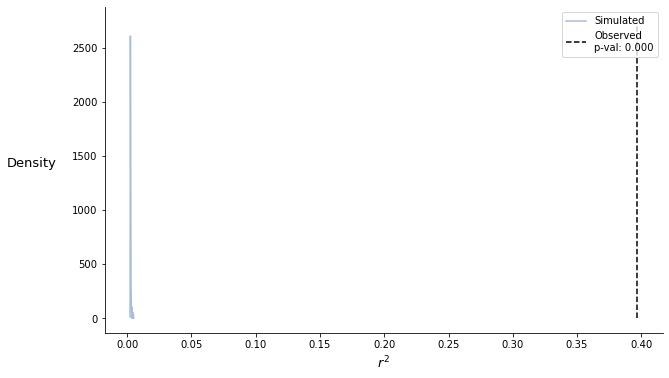

  0%|          | 0/100 [00:00<?, ?it/s]

num_cars indep num_licensed_drivers given total_travel_distance:


100%|██████████| 100/100 [00:00<00:00, 842.36it/s]

The p-value of the permutation independence test is 0.00.


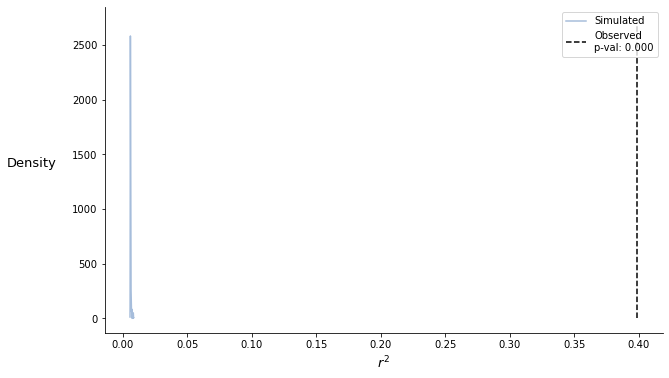

In [9]:
# Test the conditional independencies of all triplets of variables
for col_1, col_2, col_3 in triplets:
    col_1_array = drive_alone_df[col_1].values
    col_2_array = drive_alone_df[col_2].values
    col_3_array = drive_alone_df[col_3].values

    print("{} indep {} given {}:".format(col_1, col_2, col_3))
    oi.visual_permutation_test(
        col_1_array,
        col_2_array,
        z_array=col_3_array,
        num_permutations=NUM_PERMUTATIONS,
        permutation_color=PERMUTED_COLOR,
    )

## Findings
Based on the conditional independence tests, I should investigate the joint distributions between:
- total_travel_time indep num_licensed_drivers given total_travel_cost
- **total_travel_time indep num_cars given total_travel_cost**
- total_travel_cost indep num_licensed_drivers given total_travel_time
- num_licensed_drivers indep total_travel_time given total_travel_cost
- num_licensed_drivers indep total_travel_cost given total_travel_time
- **num_cars indep total_travel_time given total_travel_cost**

However, from the marginal independence tests, we are already assuming that `num_licensed_drivers` is marginally independent of travel time, cost, and distance.

Accordingly, we would only now need to investigate `num_cars` being conditionally independent of travel time given travel cost.

Let's make this assumption and proceed. I'll check the assumption afterwards.

## Step 5: Update working graph

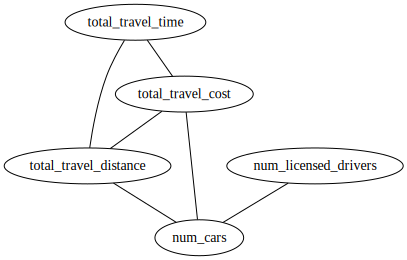

In [10]:
####
# Remove the edges given by the pairs of variables that
# passed the conditional independence tests.
####
step_5_graph = graphviz.Graph("step_5")

# Add all nodes to the graph
step_5_graph.node("T", TIME_COLUMN)
step_5_graph.node("C", COST_COLUMN)
step_5_graph.node("D", DISTANCE_COLUMN)
step_5_graph.node("L", LICENSE_COLUMN)
step_5_graph.node("A", NUM_AUTOS_COLUMN)

# Create an undirected graph respecting the removed edges
node_aliases = [
    "T",
    "C",
    "D",
]
step_5_graph.edges(list(itertools.combinations(node_aliases, 2)))
step_5_graph.edge("L", "A")
step_5_graph.edge("C", "A")
step_5_graph.edge("D", "A")

# Display the graph
step_5_graph

## Step 6: Test all "2nd-order" interactions.
In other look for conditional independencies once controlling for two variables.

In [11]:
def computed_vs_obs_r2_order_2(
    x1_array: np.ndarray,
    x2_array: np.ndarray,
    z_array: Optional[np.ndarray] = None,
    seed: Optional[int] = None,
    num_permutations: int = 100,
    progress: bool = True,
) -> Tuple[float, np.ndarray]:
    """
    Using sklearn's default LinearRegression regressor to predict `x1_array`
    given `x2_array` (and optionally, `z_array`), this function computes
    r2 using the observed `x2_array` and permuted versions of `x2_array`.

    Parameters
    ----------
    x1_array : 1D np.ndarray.
        Denotes the target variable to be predicted.
    x2_array : 1D np.ndarray.
        Denotes the explanatory variable to be used and permuted when trying to
        predict `x1_array`.
    z_array : optional, 1D ndarray or None.
        Detnoes an explanatory variable to be conditioned on, but not to be
        permuted when predicting `x1_array`. Default == None.
    seed : optional, positive int or None.
        Denotes the random seed to be used when permuting `x2_array`.
        Default == None.
    num_permutations : optional, positive int.
        Denotes the number of permutations to use when predicting `x1_array`.
        Default == 100.
    progress : optional, bool.
        Denotes whether or not a tqdm progress bar should be displayed as this
        function is run. Default == True.

    Returns
    -------
    obs_r2 : float
        Denotes the r2 value obtained using `x2_array` to predict `x1_array`,
        given `z_array` if it was not None.
    permuted_r2 : 1D np.ndarray
        Should have length `num_permutations`. Each element denotes the r2
        attained using a permuted version of `x2_array` to predict `x1_array`,
        given `z_array` if it was not None.
    """
    # Set a random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Determine how to create the predictors for the permutation test, based
    # on whether we want a marginal independence test (i.e. z_array = None)
    # or a conditional independence test (isinstance(z_array, np.ndarray))
    def create_predictors(array_2):
        if z_array is None:
            return oi._create_predictors((array_2,))
        return oi._create_predictors((array_2, z_array[:, 0], z_array[:, 1]))

    # Combine the various predictors
    combined_obs_predictors = create_predictors(x2_array)

    # Determine the number of rows being plotted
    num_rows = x1_array.shape[0]

    # Create a regressor to be used to compute the conditional expectations
    regressor = oi._make_regressor(combined_obs_predictors, x1_array)

    # Get the observed expectations
    obs_expectation = regressor.predict(combined_obs_predictors)
    obs_r2 = oi.r2_score(x1_array, obs_expectation)

    # Initialize arrays to store the permuted expectations and r2's
    permuted_expectations = np.empty((num_rows, num_permutations))
    permuted_r2 = np.empty(num_permutations, dtype=float)

    # Get the permuted expectations
    shuffled_index_array = np.arange(num_rows)

    iterable = range(num_permutations)
    if progress:
        iterable = oi.tqdm(iterable)

    for i in iterable:
        # Shuffle the index array
        np.random.shuffle(shuffled_index_array)
        # Get the new set of permuted X_2 values
        current_x2 = x2_array[shuffled_index_array]
        # Get the current combined predictors
        current_predictors = create_predictors(current_x2)
        # Fit a new model and store the current expectation
        current_regressor = oi._make_regressor(current_predictors, x1_array)
        permuted_expectations[:, i] = current_regressor.predict(
            current_predictors
        )
        permuted_r2[i] = oi.r2_score(x1_array, permuted_expectations[:, i])
    return obs_r2, permuted_r2

100%|██████████| 100/100 [00:00<00:00, 715.49it/s]


The p-value of the permutation independence test is 0.04.


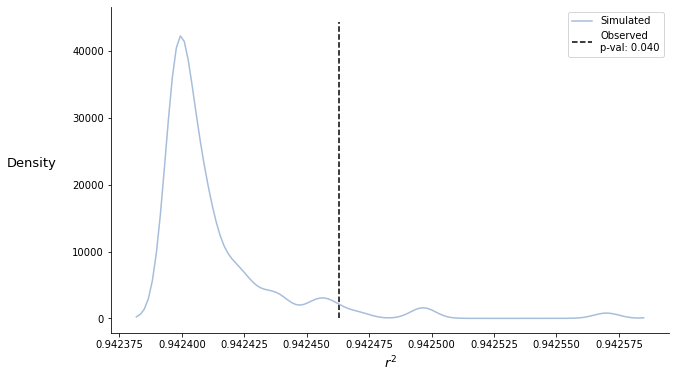

0.04

In [12]:
# Test case: x=cost, y=num_cars, z={time, distance}
cost_array = drive_alone_df[COST_COLUMN].values
num_car_array = drive_alone_df[NUM_AUTOS_COLUMN].values
test_z_array = drive_alone_df[[TIME_COLUMN, DISTANCE_COLUMN]].values

test_obs_r2, test_permuted_r2 = computed_vs_obs_r2_order_2(
    cost_array, num_car_array, test_z_array
)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 747.29it/s]


The p-value of the permutation independence test is 0.00.


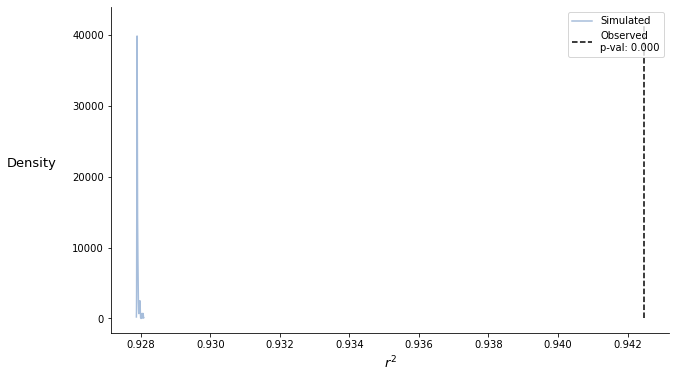

0.0

In [13]:
# Test case: x=cost, y=time, z={num_cars, distance}
cost_array = drive_alone_df[COST_COLUMN].values
time_array = drive_alone_df[TIME_COLUMN].values
test_z_array = drive_alone_df[[NUM_AUTOS_COLUMN, DISTANCE_COLUMN]].values

test_obs_r2, test_permuted_r2 = computed_vs_obs_r2_order_2(
    cost_array, time_array, test_z_array
)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 757.98it/s]


The p-value of the permutation independence test is 0.00.


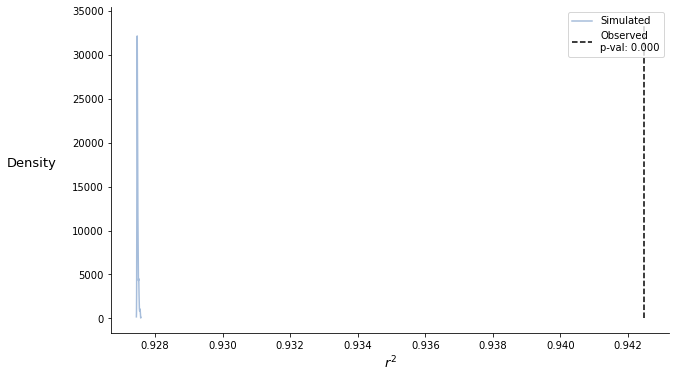

0.0

In [14]:
# Test case: x=cost, y=distance, z={num_cars, time}
cost_array = drive_alone_df[COST_COLUMN].values
distance_array = drive_alone_df[DISTANCE_COLUMN].values
test_z_array = drive_alone_df[[NUM_AUTOS_COLUMN, TIME_COLUMN]].values

test_obs_r2, test_permuted_r2 = computed_vs_obs_r2_order_2(
    cost_array, distance_array, test_z_array
)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 738.89it/s]


The p-value of the permutation independence test is 0.00.


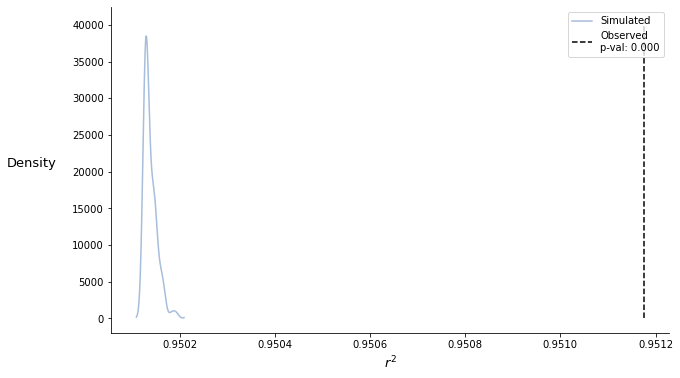

0.0

In [15]:
# Test case: x=distance, y=num_cars, z={time, cost}
distance_array = drive_alone_df[DISTANCE_COLUMN].values
num_cars_array = drive_alone_df[NUM_AUTOS_COLUMN].values
test_z_array = drive_alone_df[[TIME_COLUMN, COST_COLUMN]].values

test_obs_r2, test_permuted_r2 = computed_vs_obs_r2_order_2(
    distance_array, num_cars_array, test_z_array
)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 745.81it/s]


The p-value of the permutation independence test is 0.00.


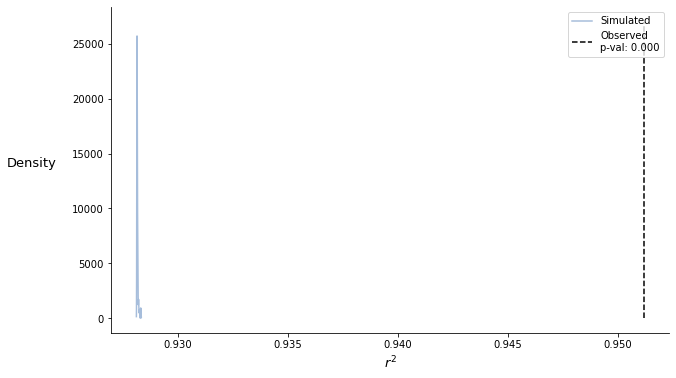

0.0

In [16]:
# Test case: x=distance, y=time, z={num_cars, cost}
distance_array = drive_alone_df[DISTANCE_COLUMN].values
time_array = drive_alone_df[TIME_COLUMN].values
test_z_array = drive_alone_df[[NUM_AUTOS_COLUMN, COST_COLUMN]].values

test_obs_r2, test_permuted_r2 = computed_vs_obs_r2_order_2(
    distance_array, time_array, test_z_array
)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 813.47it/s]


The p-value of the permutation independence test is 0.06.


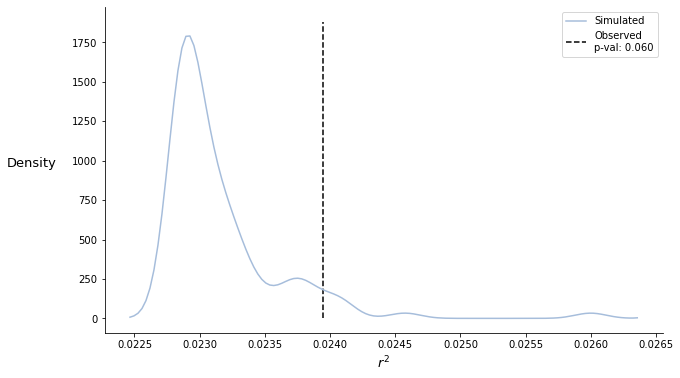

0.06

In [17]:
# Test case: x=num_cars, y=cost, z={time, distance}
cost_array = drive_alone_df[COST_COLUMN].values
num_car_array = drive_alone_df[NUM_AUTOS_COLUMN].values
test_z_array = drive_alone_df[[TIME_COLUMN, DISTANCE_COLUMN]].values

test_obs_r2, test_permuted_r2 = computed_vs_obs_r2_order_2(
    num_car_array, cost_array, test_z_array
)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

### Findings
Based on the "second-order" conditional independence tests, the only edges that are plausible to exclude is the edge between cost and number of automobiles per household.

The probability of those variables being conditionally independent given travel distance and travel time is low, but let's go with it for the moment.


## Step 7: Update working graph

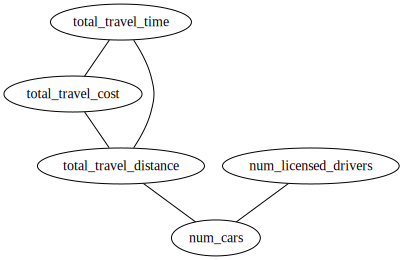

In [18]:
# Remove the edges given by the pairs of variables that
# passed the 2nd order conditional independence tests.
step_7_graph = graphviz.Graph("step_7")

# Add all nodes to the graph
step_7_graph.node("T", TIME_COLUMN)
step_7_graph.node("C", COST_COLUMN)
step_7_graph.node("D", DISTANCE_COLUMN)
step_7_graph.node("L", LICENSE_COLUMN)
step_7_graph.node("A", NUM_AUTOS_COLUMN)

# Add edges to the graph
node_aliases = [
    "T",
    "C",
    "D",
]
step_7_graph.edges(list(itertools.combinations(node_aliases, 2)))
step_7_graph.edge("L", "A")
step_7_graph.edge("D", "A")

# Display the graph
step_7_graph

## Step 8: Orient the edges that can be oriented

> For each triple of vertices X, Y, Z such that the pair X, Y and the pair Y, Z are each adjacent in C but the pair X , Z are not adjacent in C, orient X - Y - Z as X -> Y <- Z if and only if Y is not in Sepset(X ,Z).

Here, `total_travel_distance` and `num_licensed_drivers` are not adjacent in the graph AND they were deemed marginally independent (i.e. `num_cars` did not "separate" them--these two variables were already independent / separate). Accordingly, we should orient the graph such that both `total_travel_distance` and `num_licensed_drivers` have directed edges pointing to `num_cars`.

The result of following the PC Algorithm to its conclusion, assuming that the algorithms assumptions are met, is a "faithful indistinguishability class" where:
- `num_licensed_drivers` $\rightarrow$ `num_cars` $\leftarrow$ `total_travel_distance`
- `total_travel_distance` -- `total_travel_cost` -- `total_travel_time`
- `total_travel_distance` -- `total_travel_time`

The directionality of relationships between time, cost, and distance are not given.

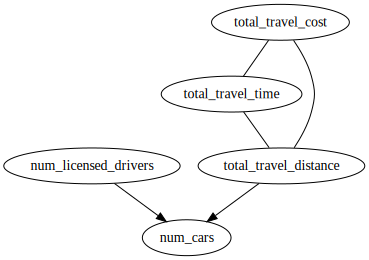

In [19]:
####
# Remove the edges given by the pairs of variables that
# passed the 2nd order conditional independence tests.
####
step_8_graph = graphviz.Digraph("step_8")

# Add all nodes to the graph
step_8_graph.node("T", TIME_COLUMN)
step_8_graph.node("C", COST_COLUMN)
step_8_graph.node("D", DISTANCE_COLUMN)
step_8_graph.node("L", LICENSE_COLUMN)
step_8_graph.node("A", NUM_AUTOS_COLUMN)

# Add edges to the graph
step_8_graph.edge("L", "A")
step_8_graph.edge("D", "A")
step_8_graph.edge("T", "D", dir="none")
step_8_graph.edge("C", "D", dir="none")
step_8_graph.edge("C", "T", dir="none")

# Display the graph
step_8_graph

## Step 9: Use domain knowledge to further orient the graph

Based on the computational data generating process, i.e. through the use of travel skims to construct the data and how the travel skims were constructed, we know that:
- `total_travel_distance` $\rightarrow$ `total_travel_cost`
- `total_travel_distance` $\rightarrow$ `total_travel_time`

See http://analytics.mtc.ca.gov/foswiki/bin/view/Main/SimpleSkims for more details.

This leaves the final set of relations as
- `num_licensed_drivers` $\rightarrow$ `num_cars` $\leftarrow$ `total_travel_distance`
- `total_travel_time` $\leftarrow$ `total_travel_distance` $\rightarrow$ `total_travel_cost`
- `total_travel_cost` -- `total_travel_time`

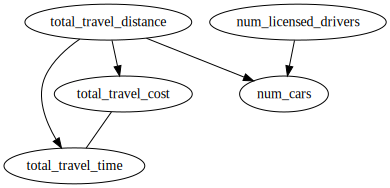

In [24]:
# Remove the edges given by the pairs of variables that
# passed the 2nd order conditional independence tests.
step_9_graph = graphviz.Digraph("step_9")

# Add all nodes to the graph
step_9_graph.node("T", TIME_COLUMN)
step_9_graph.node("C", COST_COLUMN)
step_9_graph.node("D", DISTANCE_COLUMN)
step_9_graph.node("L", LICENSE_COLUMN)
step_9_graph.node("A", NUM_AUTOS_COLUMN)

# Add edges to the graph
step_9_graph.edge("L", "A")
step_9_graph.edge("D", "A")
step_9_graph.edge("D", "T")
step_9_graph.edge("D", "C")
step_9_graph.edge("C", "T", dir="none")

# Display the graph
utils.create_graph_image(
    step_9_graph, output_name = PLOT_TITLE, output_type = "pdf"
)

step_9_graph.graph_attr.update(size="10,6")
step_9_graph

# Conclusions
Of course, anything about the graph above and any comments below hinge on whether the tests used in the algorithm were any good. We have little certainty because we performed no model checks of the models being used in the independence tests.

However, the final graph is very plausible.

We are left with questions of whether:
- `total_travel_time` $\rightarrow$ `total_travel_cost` or
- `total_travel_cost` $\rightarrow$ `total_travel_time` or
- `total_travel_time` $\leftarrow$ `unobserved_confounder` $\rightarrow$ `total_travel_cost`

One immediate confounder that is unobserved in this causal graph is whether one crosses the bay bridge.
If one commutes across the Bay Bridge, then one's travel time will likely be increased due traffic, and one's travel cost will be increased due to paying tolls.

In the end, note that the graph above differs from the original graph that we conjectured, shown below.
Our original graph was created with some, but minimal, thought.
In particular, our original graph missed the edge `num_licensed_driver` $\rightarrow$ `num_cars` and the undirected edge `total_travel_time` -- `total_travel_cost`.

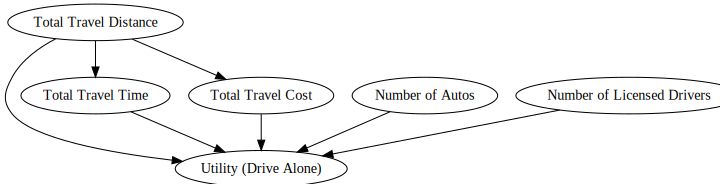

In [21]:
original_graph = DRIVE_ALONE_UTILITY.draw()
original_graph.graph_attr.update(size="10,6")
original_graph